## Gemini spectrum

Spectral resolution of 70km/s for a ~23rd mag object

In [1]:
#import ipympl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
from astropy.io import fits
from glob import glob
import lightkurve as lk
#%matplotlib notebook 
from astropy.wcs import WCS

from mpfit import mpfit

In [2]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
fig_width_pt = 240.0  # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inches
golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height =fig_width*golden_mean       # height in inches
fig_size = [fig_width,fig_height]

In [3]:
def F(x, p):

	# The model to be fitted to the data

	return  p[0] * np.exp(-((x-p[1])**2)/(2*p[2]**2))



def myfunct(p, fjac=None, x=None, y=None, err=None):

	# The model evaluated at the provided x values with parameters stored in p

	model = F(x, p)

	# The deviates are the differences between the measurements y and the model 

	# evaluated at each point x normalised by the standard deviation in the 

	# measurement.

	deviates = np.array((y - model) / err, dtype=float)

	# We return p status flag and the deviates.

	return 0, deviates

model = lambda x, p : p[0] * np.exp(-((x-p[1])**2)/(2*p[2]**2))	# the model.

In [120]:
path = '/Users/ryanr/Documents/PhD/coding/Kepler/pipelines/203830112/gemini/C11_CVobj_clean.fits'
hdu = fits.open(path)
header = hdu[0].header

In [121]:
data = hdu[0].data
sig_data = 0.2 * data
sig_data[:] = 0.02
wav = np.arange(data.shape[0]) * header['CDELT1'] + header['CRVAL1']

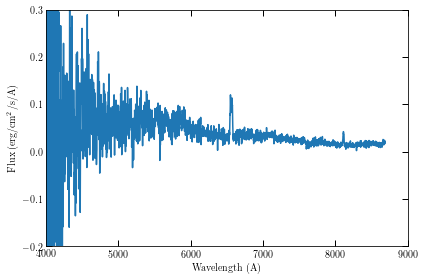

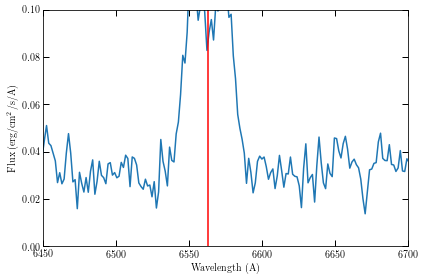

In [6]:
plt.figure()
plt.plot(wav,data)
plt.ylim(-.2,.3)
plt.xlim(4000,9000)
plt.ylabel('Flux (erg/cm$^2$/s/A)')
plt.xlabel('Wavelength (A)')
plt.tight_layout()

plt.figure()
plt.plot(wav,data)
plt.axvline(6562.8,color='red')

plt.ylim(0,0.1)
plt.xlim(6450,6700)
plt.ylabel('Flux (erg/cm$^2$/s/A)')
plt.xlabel('Wavelength (A)')
plt.tight_layout()

In [7]:
np.where(wav <=6700)[0][-1]

1818

In [8]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

/Users/ryanr/anaconda3/lib/python3.5/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


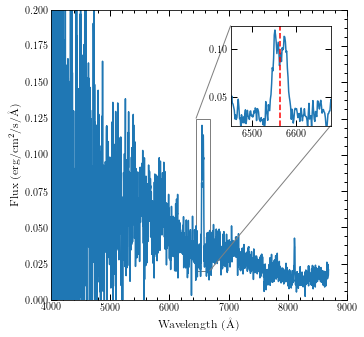

In [9]:
fig, ax = plt.subplots()
ax.plot(wav,data)
plt.minorticks_on()
plt.ylim(0,.2)
plt.xlim(4000,9000)
plt.ylabel(r'Flux (erg/cm$^2$/s/\AA)',fontsize=12)
plt.xlabel(r'Wavelength (\AA)',fontsize=12)
axins = inset_axes(ax,width='25%',height='25%',bbox_to_anchor=([-70,-70,400,400]))
axins.plot(wav[1652:1817],data[1652:1817])
axins.axvline(6562.8,color='red',ls='--')

# sub region of the original image
x1, x2, y1, y2 = 6450, 6680, 0.020, 0.125
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)


# draw a bbox of the region of the inset axes in the parent axes and
# connecting lines between the bbox and the inset axes area
mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")
#fig.set_size_inches(1.5*fig_width,1.5*fig_width)
plt.tight_layout()
fig.set_size_inches(1.5*fig_width,1.5*fig_width)
plt.savefig('Gem_spec.pdf');

In [10]:
-2.5*np.log10(0.02*(6500**2)/3e18) - 48.6

-17.224338635575076

In [11]:
-2.5*np.log10(1e-13) - 48.6

-16.1

In [12]:
index = np.where(np.isclose(wav,6560,atol=100))

In [10]:
#beta = ((ls/lo)**2-1)/(1+(ls/lo)**2)
def Velocity(lo):
    ls = 6562.8
    c = 299792458
    beta = ((ls/lo)**2-1)/(1+(ls/lo)**2)
    vel = c*beta
    return vel

Calculate the orbital radius of the superhump

In [14]:
omega = 2*np.pi/(80*60) # 80 mins for a complete orbit
r = 4E5/omega

In [15]:
rkm = r/1000
rwdr = rkm/7000

In [16]:
rkm

305577.4907364391

## Fit the double peak

In [118]:
c = 299792458
index = np.where(np.isclose(wav,6560,atol=100))
speed = wav[index]-1.06
speed = Velocity(speed)/1000

In [14]:
from astropy.modeling import models, fitting

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.005635605401613303
            Iterations: 47
            Function evaluations: 379
            Gradient evaluations: 47


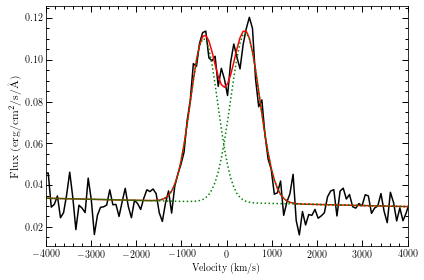

In [36]:
xdata = wav[index]  #-1.06
ydata = data[index]
ind = (xdata <= 6525) | (xdata >= 6600)
# Linear model
l1 = models.Polynomial1D(1)#(0.1,0.02)
l_init = l1
fitter = fitting.LinearLSQFitter()
l_fit = fitter(l_init, xdata[ind], ydata[ind])

detrend = ydata - l_fit(xdata)

g1 = models.Gaussian1D(0.1, 6550, 1.0) # First gaussian - init guess
g2 = models.Gaussian1D(0.9, 6570, 1.0) # Second gaussian - init guess

g_tot = g1 + g2 # Model is two sum of two Gaussians

# Now to fit the data create a new superposition with initial
# guesses for the parameters:
gg_init = g_tot
fitter = fitting.SLSQPLSQFitter()
gg_fit = fitter(gg_init, xdata, detrend)

# Plot the data with the best-fit model
plt.figure()
plt.plot(speed, detrend + l_fit(xdata), 'k')
plt.plot(speed, gg_fit[0](xdata) + gg_fit[1](xdata) + l_fit(xdata), 'r-')
plt.plot(speed, gg_fit[0](xdata) + l_fit(xdata), 'g:')
plt.plot(speed, gg_fit[1](xdata) + l_fit(xdata), 'g:')
plt.xlim(-4000,4000)
#plt.axvline(6562.8,ls = '--')

plt.minorticks_on()
plt.ylabel(r'Flux (erg/cm$^2$/s/\AA)',fontsize=12)
plt.xlabel(r'Velocity (km/s)')
plt.tight_layout()
fig.set_size_inches(1.5*fig_width,1.5*fig_width)
plt.savefig('Spec_fit.pdf');


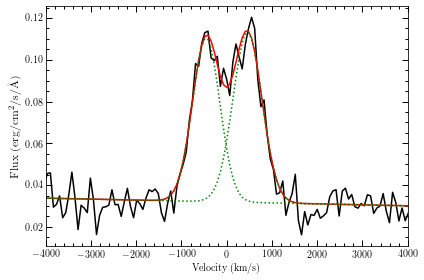

In [99]:
xdata = speed#wav[index]  #-1.06
ydata = data[index]
ind = (xdata <= -2000) | (xdata >= 2000)
# Linear model
l1 = models.Polynomial1D(1)#(0.1,0.02)
l_init = l1
fitter = fitting.LinearLSQFitter()
l_fit = fitter(l_init, xdata[ind], ydata[ind])

detrend = ydata - l_fit(xdata)

g1 = models.Gaussian1D(0.11, -480, 340.0) # First gaussian - init guess
g2 = models.Gaussian1D(0.13, 450, 340.0) # Second gaussian - init guess

g_tot = g1 + g2 # Model is two sum of two Gaussians

# Now to fit the data create a new superposition with initial
# guesses for the parameters:
gg_init = g_tot
fitter = fitting.LevMarLSQFitter()
gg_fit = fitter(gg_init, xdata, detrend)

# Plot the data with the best-fit model
plt.figure()
plt.plot(speed, detrend + l_fit(xdata), 'k')
plt.plot(speed, gg_fit[0](xdata) + gg_fit[1](xdata) + l_fit(xdata), 'r-')
plt.plot(speed, gg_fit[0](xdata) + l_fit(xdata), 'g:')
plt.plot(speed, gg_fit[1](xdata) + l_fit(xdata), 'g:')
plt.xlim(-4000,4000)
#plt.axvline(6562.8,ls = '--')

plt.minorticks_on()
plt.ylabel(r'Flux (erg/cm$^2$/s/\AA)',fontsize=12)
plt.xlabel(r'Velocity (km/s)')
plt.tight_layout()
fig.set_size_inches(1.5*fig_width,1.5*fig_width)
plt.savefig('Spec_fit.pdf');


FWHM of gaussians

In [98]:
FWHM1 = 2*np.sqrt(2*np.log(2))*gg_fit[0].stddev[0]
FWHM2 = 2*np.sqrt(2*np.log(2))*gg_fit[1].stddev[0]
print('FWHM: ', FWHM1, FWHM2)

mean1 = gg_fit[0].mean[0]
mean2 = gg_fit[1].mean[0]
DP = abs(mean1-mean2)
print('mean: ', mean1, mean2)
print('Difference = ', DP)

FWHM:  713.0320299610247 758.2224692328899
mean:  -454.6311406256193 458.8810551225916
Difference =  913.5121957482108


In [125]:
sig1 = 310
sig1_per = 60/sig1

sig2 = 330
sig2_per = 60/sig2

FWHM1 = 2*np.sqrt(2*np.log(2))*sig1
FWHM2 = 2*np.sqrt(2*np.log(2))*sig2

FWHM1_err = FWHM1 * sig1_per 
FWHM2_err = FWHM2 * sig2_per

print('G1', FWHM1,FWHM1_err)
print('G2', FWHM2,FWHM2_err)

G1 729.9942139595943 141.28920270185696
G2 777.0906148602132 141.28920270185696


In [126]:
sig2_per

0.18181818181818182

In [54]:
gg_fit[0].stddev[0]

339.99998137504434

In [55]:
gg_fit[1].stddev[0]

339.9999681206084

FWHM:  712.8195032522109 757.7335361685338
mean:  -502.88212615342087 410.36179798299816


In [69]:
gg_fit[0].error

AttributeError: 'Gaussian1D' object has no attribute 'error'

In [64]:
FWHM2

757.7335361685338

Double peak seperation

In [20]:
6562

6562

In [21]:
DP = gg_fit[1].mean*1 - gg_fit[0].mean*1
print(DP)

20.012840536983276


In [22]:
gg_fit[0]

<Gaussian1D(amplitude=0.08162542, mean=6553.81360076, stddev=7.05133427)>

In [23]:
gg_fit[1]

<Gaussian1D(amplitude=0.07837323, mean=6573.8264413, stddev=6.65186914)>

In [24]:
# Velocity offset
Velocity(6563.86)/1000

-48.41749590644532

In [25]:
v_b = Velocity(gg_fit[0].mean*1-1.06)/1000
print(v_b)
# Error here is introduced by the wavelength resolution, 1.51 A/pix
v_bu = Velocity(gg_fit[0].mean*1-1.06 + 1.51)/1000 

v_b-v_bu

459.2765269757107


69.07531987825229

In [26]:
v_r = Velocity(gg_fit[1].mean*1-1.06)/1000
print(v_r)
v_ru = Velocity(gg_fit[1].mean*1-1.06 + gg_fit[1].stddev*1)/1000

v_r-v_ru

-454.9270453931832


303.24574593583725

In [27]:
DP = abs(v_b-v_r)

In [28]:
# calculate the radius from the relation omega = velocity/radius
vel = Velocity(gg_fit[0].mean*1-1.06)
omega = 2*np.pi/(0.05704*24*60**2) # 80 mins for a complete orbit
r = vel/omega
print(r)

360236438.8554416


Calculate the WD mass

In [127]:
G = 6.674e-11

Mass = vel**2*r / G
print(Mass/1.988435e30,'Msun')

NameError: name 'vel' is not defined

In [30]:
q = 0.06
Mass*q/1.988435e30

0.03435498706969049

Calculate the orbital radius of the BD using the assumption that the disk is at R32, where disk angular velocity is 3 times the angular velocity of the BD.

In [31]:
r_bd = (9*G*Mass/omega**2)**(1/3)
print(r_bd)
print(r_bd/r)

749321988.9370296
2.080083823051902


Calculate the Roche Lobe radius

In [32]:
1/q

16.666666666666668

In [33]:
r1 = (0.49*(1/q)**(2/3)/(0.6*(1/q)**(2/3)+np.log(1+(1/q)**(1/3)))) * r_bd
print(r1)

462216552.87089336


In [34]:
r1 = (0.38+0.2*np.log(1/q)) 
r1

0.9426821433520073

## Fit a single Gaussian to get the FWHM

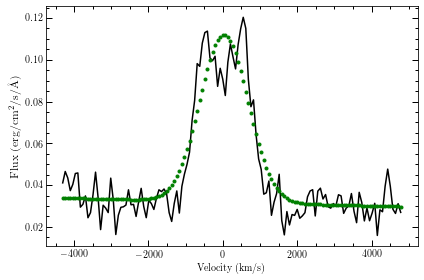

In [122]:
xdata = speed #-1.06
ydata = data[index]
ind = (xdata <= -2000) | (xdata >= 2000) #ind = (xdata <= 6525) | (xdata >= 6600)
# Linear model
l1 = models.Polynomial1D(1)#(0.1,0.02)
l_init = l1
fitter = fitting.LinearLSQFitter()
l_fit = fitter(l_init, xdata[ind], ydata[ind])

detrend = ydata - l_fit(xdata)

g1 = models.Gaussian1D(0.1, 0, 500.0) # First gaussian - init guess
#g2 = models.Gaussian1D(0.9, 6570, 1.0) # Second gaussian - init guess

g_tot = g1 #+ g2 # Model is two sum of two Gaussians

# Now to fit the data create a new superposition with initial
# guesses for the parameters:
gg_init = g_tot
fitter = fitting.LevMarLSQFitter()
gg_fit = fitter(gg_init, xdata, detrend)

# Plot the data with the best-fit model
plt.figure()
plt.plot(speed, detrend + l_fit(xdata), 'k')
plt.plot(speed, gg_fit(xdata) + l_fit(xdata), 'g.')

plt.minorticks_on()
plt.ylabel(r'Flux (erg/cm$^2$/s/\AA)',fontsize=12)
plt.xlabel(r'Velocity (km/s)')
plt.tight_layout()
fig.set_size_inches(1.5*fig_width,1.5*fig_width)
#plt.savefig('Spec_fit.pdf');


In [123]:
gg_fit.stddev[0]

647.9905123547087

In [124]:
std_pererror = 30/650

# FWHM 
FWHM = 2*np.sqrt(2*np.log(2))*650#gg_fit.stddev[0]
FWHMerr = FWHM*std_pererror
print(FWHM,FWHMerr)

1530.633029270117 70.64460135092848


# Calculate inclination assuming 0.8 Msun 

In [113]:
Msun = 1.988435e30 # kg
vt = (omega*G*0.58*Msun)**(1/3)
i = np.arcsin((vel)/vt)*180/np.pi
print('Velocity ',vt/1000)
print('Inclination ',i)

Velocity  461.25108554279717
Inclination  84.69654374090898


In [133]:
lowest_mass = 450000**3/(omega*G*Msun)

In [134]:
lowest_mass

0.17952795189499665

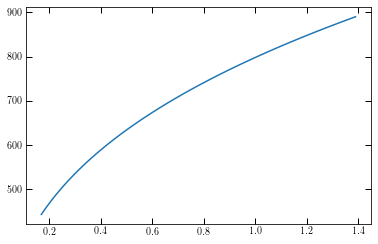

In [135]:
G = 6.674e-11
Msun = 1.988435e30 # kg
mass = np.arange(0.17,1.4,0.01)
omega = 2*np.pi/(0.05704*24*60**2/3) # 80 mins for a complete orbit

plt.figure()
plt.plot(mass,(omega*G*mass*Msun)**(1/3)/1000)


In [48]:
rwd = 7000E3 # radius of white dwarf in m
R = vt/omega
np.arccos(rwd/R)

1.5534137114087734

In [57]:
redr = np.cos(60*np.pi/180)*R

In [58]:
rwd/redr

0.03476348004880479

In [59]:
redr

201360738.05535668

In [60]:
rwd/R

0.0173817400244024

In [64]:
Rinner = rwd/np.cos(60*np.pi/180)

In [67]:
(R - Rinner)/1E6

388.72147611071324

In [51]:
low = 49
mid = 63
high = 88

In [ ]:
Msun = 1.988435e30
vt = (omega*G*0.58*Msun)**(1/3)
i = np.arcsin((vel)/vt)*180/np.pi
print('Velocity ',vt/1000)
print('Inclination ',i)

# Calculate mass assuming inclination

In [119]:
inc = 90
#inc = np.arange(0,90,0.01)
vt = (vel)/np.sin(inc*np.pi/180)
M = (vt)**(3)/(omega*G)
print('Velocity ',vt/1000)
print('Mass ',M/Msun)

Velocity  459.2765269757107
Mass  0.5725831178281748


(0, 1.4)

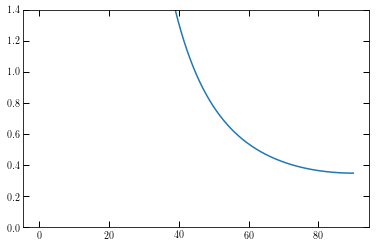

In [116]:
plt.figure()
plt.plot(inc,M/Msun)
plt.ylim(0,1.4)

In [78]:
inc = 40
vt = (vel)/np.sin(inc*np.pi/180)
M = (vt)**(3)/(omega*G)
print('Velocity ',vt/1000)
print('Mass ',M/Msun)

Velocity  714.5074361338122
Mass  2.1559369149773024


# Make the CV plot from that paper

In [77]:
qs = np.array([[0.55,0.21],
             [0.51,0.08],
             [0.359,0.013],
             [0.32,0.08],
             [0.25,0.03],
             [0.15,0.015],
             [0.102,0.003],
             [0.19,0.03],
             [0.055,0.002],
             [0.088,0.013],
             [0.069,0.003]])

DPFWHM = np.array([[0.5551,0.0007],
                   [0.5402,0.0013],
                   [0.5663,0.0013],
                   [0.5760,0.0035],
                   [0.5681,0.0007],
                   [0.5825,0.0027],
                   [0.6100,0.0003],
                   [0.5737,0.0043],
                   [0.6311,0.0016],
                   [0.6150,0.0007],
                   [0.5777,0.0025]])

In [78]:
qq = np.arange(0,0.8,0.01)
alpha = 0.42
beta = 0.83
f = (0.49*(1+qq)**(-1))/(0.6+qq**(2/3)*np.log(1+qq**(-1/3)))
thing = 3**(1/3)*(1+qq)**(2/3)*beta*(alpha*f)**(1/2)

/Users/ryanr/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in power
/Users/ryanr/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in multiply


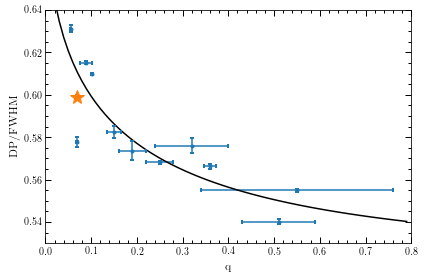

In [95]:
plt.figure()
plt.plot(qq,thing,'k')
plt.errorbar(qs[:,0],DPFWHM[:,0],xerr=qs[:,1],yerr=DPFWHM[:,1],fmt='.',capsize=2,capthick=2,label='CVs')
plt.errorbar(0.07,DP/FWHM,yerr=0.001,fmt='*',capsize=2,capthick=2,ms=15,label = r'KSN--BS C11a')
plt.xlabel('q',fontsize=12)
plt.ylabel('DP/FWHM',fontsize=12)
#plt.legend()

plt.xlim(0,0.8)
plt.ylim(0.53,0.64)
plt.tight_layout()
plt.minorticks_on()
fig.set_size_inches(1.5*fig_width,1.5*fig_width)
plt.savefig('DPFWHM_q.pdf')

# Fit Model with new datapoint

In [43]:
qs = np.array([[0.55,0.21],
             [0.51,0.08],
             [0.359,0.013],
             [0.32,0.08],
             [0.25,0.03],
             [0.15,0.015],
             [0.102,0.003],
             [0.19,0.03],
             [0.055,0.002],
             [0.088,0.013],
             [0.069,0.003],
               [0.07,0.01]])

DPFWHM = np.array([[0.5551,0.0007],
                   [0.5402,0.0013],
                   [0.5663,0.0013],
                   [0.5760,0.0035],
                   [0.5681,0.0007],
                   [0.5825,0.0027],
                   [0.6100,0.0003],
                   [0.5737,0.0043],
                   [0.6311,0.0016],
                   [0.6150,0.0007],
                   [0.5777,0.0025],
                  [20/FWHM,0.001]])

In [85]:
from astropy.modeling.models import custom_model
from astropy.modeling.fitting import LevMarLSQFitter

In [86]:
@custom_model
def Curve(Q, Alpha = alpha, Beta = beta):
    F = (0.49*(1+Q)**(-1))/(0.6+Q**(2/3)*np.log(1+Q**(-1/3)))
    return 3**(1/3)*(1+Q)**(2/3)*Beta*(Alpha*F)**(1/2)

In [87]:
m_init = Curve()
fit = LevMarLSQFitter()
m = fit(m_init, qs[:,0], DPFWHM[:,0],weights=1.0/np.sqrt(qs[:,1]**2 + DPFWHM[:,1]**2))

In [47]:
m.Alpha

Parameter('Alpha', value=0.438691083797244)

In [48]:
alpha

0.42

In [49]:
m.Beta

Parameter('Beta', value=0.8159659415372005)

In [50]:
beta

0.83

/Users/ryanr/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in power
  app.launch_new_instance()
/Users/ryanr/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in multiply
  app.launch_new_instance()


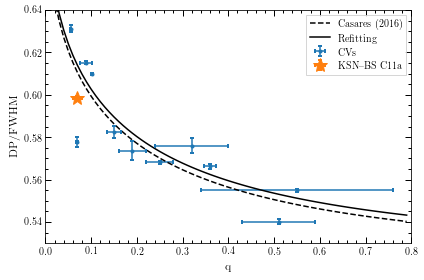

In [88]:
plt.figure()
plt.plot(qq,thing,'k--',label='Casares (2016)')
plt.plot(qq,m(qq),'k-', label='Refitting')
plt.errorbar(qs[:,0],DPFWHM[:,0],xerr=qs[:,1],yerr=DPFWHM[:,1],fmt='.',capsize=2,capthick=2,label='CVs')
plt.errorbar(0.07,913/FWHM,xerr=0.01,yerr=0.001,fmt='*',capsize=2,capthick=2,ms=15,label = r'KSN--BS C11a')
plt.xlabel('q',fontsize=12)
plt.ylabel('DP/FWHM',fontsize=12)
plt.legend()

plt.xlim(0,0.8)
plt.ylim(0.53,0.64)
plt.tight_layout()
plt.minorticks_on()
fig.set_size_inches(fig_width,fig_height)
#plt.savefig('DPFWHM_q.pdf')

In [107]:
# saving
saves = np.zeros((2,len(speed)))

saves[0,:] = speed
saves[1,:] = detrend

np.save('spectra',saves)

# Calculate system parameters

In [187]:
ind = np.where((data[0] > -1200) & (data[0] <1200))[0]
ind = ind[2:-3]
# Area above the continum 
A = np.trapz(data[1,ind],x=wav[ind]-1.06)
# error in the area, calculate by adding an rms value of 0.01
upper = np.trapz(data[1,ind]+0.01,x=wav[ind]-1.06)
lower = np.trapz(data[1,ind]-0.01,x=wav[ind]-1.06)

print('{val} +{up} -{low}'.format(val=A, up=upper-A, low=A-lower))
print('Percent error = ', np.round(upper-A,1)/np.round(A,1)*100,'%')

#Aerr
I = 0.08 
Ierr = 0.01

EW = A/I
EWerr = EW * ((upper-A)/A + Ierr/I)

print('EW = ',EW,'+-',EWerr)
print('Percent error = ',EWerr/EW*100,'%')

2.6293072201845358 +0.4369247925281483 -0.4369247925281483
Percent error =  15.384615384615385 %
EW =  32.8663402523067 +- 9.569852438140192
Percent error =  29.117487267139637 %


Calculate the inclination by rearranging equation 9 of Casares 2015:

$EW \approx \frac{B}{cos(i)}$ 

where $EW$ is the effective width of the $H_\alpha$ line, $B = 9\pm8~A$ and $i$ is the inclination

In [196]:
inc = np.arccos((9)/EW)*180/np.pi
incu = np.arccos((9-8)/(EW+EWerr))*180/np.pi
incl = np.arccos((9+8)/(EW-EWerr))*180/np.pi
print('i = {val} +{up} -{low}'.format(val=inc, up=incu-inc, low=inc-incl))


i = 74.10731733205797 +14.54239462549495 -30.970555755735255


Calculate the disk velocity:

$v_T = \frac{v_o}{sin(i)}$

In [264]:
vel_obs = 450 #km/s
vel_obs_err = 60
vel = vel_obs / np.sin(inc*np.pi/180)
velu = (vel_obs + vel_obs_err) / np.sin((incl)*np.pi/180)
vell = (vel_obs - vel_obs_err) / np.sin((incu)*np.pi/180)
print('v = {val} +{up} -{low}'.format(val=vel, up=velu-vel, low=vel-vell))

v = 467.88427301861435 +278.0109854913807 -77.77594452487722


Calculate the WD mass:

$M = \frac{v^3}{\omega G}$

In [272]:
mass = (vel*1000)**3 / (omega*G) / Msun
massu = (velu*1000)**3 / (omega*G) / Msun
massl = (vell*1000)**3 / (omega*G) / Msun
print('Mass = {val} +{up} -{low}'.format(val=mass, up=massu-mass, low=mass-massl))

Mass = 0.2017947566681528 +0.6157811306507259 -0.08483129809323309


In [269]:
mass/Msun

0.2017947566681528

Those bounds are completely useless. Constrain by the maximum velocity set by 1.4 solar mass.

In [261]:
# disk orbital frequency
omega = 2*np.pi/(0.05704*24*60**2)*3 # 1/s

G = 6.674e-11 # SI
Msun = 1.988435e30 # kg

vt = (omega*G*1.4*Msun)**(1/3)
i = np.arcsin((vel_obs*1000)/vt)*180/np.pi
print('Velocity ',vt/1000)
print('Inclination ',i)

Velocity  892.3690519715939
Inclination  30.283281404908166


In [247]:
incu

88.64971195755292

Calculate WD mass using eq 8 from Casares 2015:

$FWHM \approx A\left(\frac{M_1}{P}\right)^{1/3}sin(i)$

where $FWHM$ is the full width half maximum of the $H_\alpha$ emission line, $A = 876\pm48$, $M_1$ is the WD mass, $P$ is the disk period, and $i$ is the inclination. 

$FWHM$ is in km/s, $M_1$ is in $M_\odot$, and $P$ is in days.

In [242]:
FWHM = 2*np.sqrt(2*np.log(2))*650#gg_fit.stddev[0]
std_pererror = 30/650
FWHMerr = FWHM*std_pererror

P = 0.05704 / 3
Magic_A = 876
Magic_Aerr = 48
mass = (FWHM/(Magic_A*np.sin(inc*np.pi/180)))**3*P
massu = ((FWHM+FWHMerr)/((Magic_A - Magic_Aerr)*np.sin((incu)*np.pi/180)))**3*P
massl = ((FWHM-FWHMerr)/((Magic_A + Magic_Aerr)*np.sin((incl)*np.pi/180)))**3*P

print('M = {val} +{up} -{low}'.format(val=mass, up=massu-mass, low=mass-massl))

M = 0.11400843570219636 +0.02362660245248009 --0.12063780464694733


In [227]:
FWHM-FWHMerr

1459.9884279191886

In [224]:
Magic_A*np.sin(inc*np.pi/180)

842.516029565963

In [226]:
Magic_A*np.sin((inc+incl)*np.pi/180)

778.8204622240754

In [ ]:
(FWHM/(Magic_A*np.sin(inc*np.pi/180)))**3*P

<IPython.core.display.Javascript object>


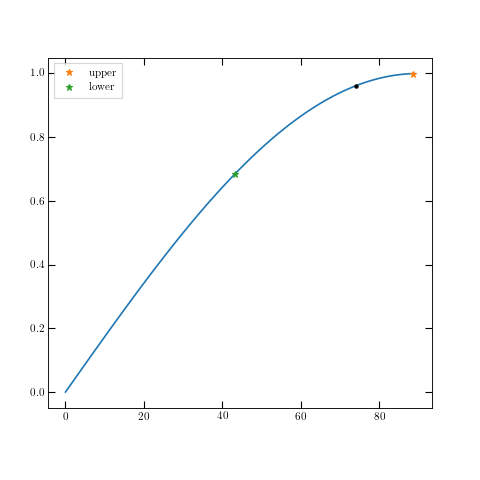

In [263]:
x = np.arange(0,90)
plt.figure()
plt.plot(x,np.sin(x*np.pi/180))
plt.plot(inc, np.sin(inc*np.pi/180),'k.')
plt.plot((incu), np.sin((incu)*np.pi/180),'*',label='upper')
plt.plot((incl), np.sin((incl)*np.pi/180),'*',label='lower')
plt.legend()

<IPython.core.display.Javascript object>


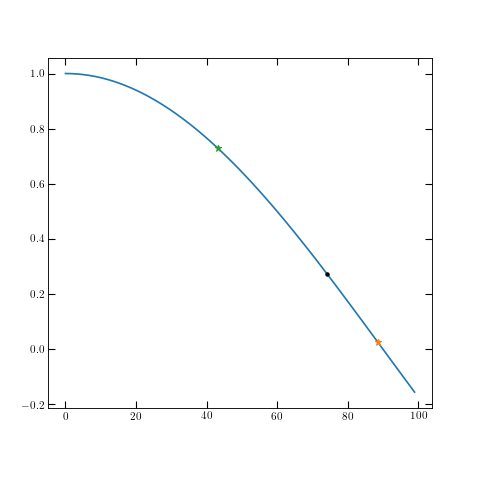

In [240]:
x = np.arange(0,100)
plt.figure()
plt.plot(x,np.cos(x*np.pi/180))
plt.plot(inc, np.cos(inc*np.pi/180),'k.')
plt.plot((incu), np.cos((incu)*np.pi/180),'*')
plt.plot((incl), np.cos((incl)*np.pi/180),'*')

In [235]:
inc+incu

162.7570292896109

In [236]:
incu

88.64971195755292